In [42]:
import os
import re
import functools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf

from PIL import Image
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from Encoder import Encoder
import string

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from keras.preprocessing.image import load_img
from spacy.lang.en.stop_words import STOP_WORDS

# Loading Data

In [4]:
def parse_input(x):
    if os.path.exists("/users/vspvikram/Downloads/AML_project/ecgen-radiology/%s.xml" %x):
        f = open("/users/vspvikram/Downloads/AML_project/ecgen-radiology/%s.xml" %x, 'r')
        soup = BeautifulSoup(f, "html.parser")
        reports = soup.find(label="IMPRESSION").get_text().lower()
        return re.sub(r'[\W]', ' ', reports)
    
image = pd.Series(os.listdir('/users/vspvikram/Downloads/AML_project/NLMCXR_png'))
number = image.apply(lambda x: x.split('_')[0][3:])
report = number.apply(parse_input)

In [5]:
df = pd.DataFrame({'Image': image, 'Number': number, 'Caption': report}).dropna().sort_values(['Number']).reset_index(drop
                                                                                                                     =True)
df.head()

,Image,Number,Caption
0,CXR1_1_IM-0001-4001.png,1,normal chest x xxxx
1,CXR1_1_IM-0001-3001.png,1,normal chest x xxxx
2,CXR10_IM-0002-2001.png,10,no acute cardiopulmonary process
3,CXR10_IM-0002-1001.png,10,no acute cardiopulmonary process
4,CXR100_IM-0002-2001.png,100,no active disease


# Sample Images and report

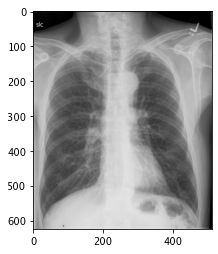

hyperinflated chest as before  compatible with emphysema  clear lungs  mediastinal contour within normal limits  no acute cardiopulmonary abnormality identified 



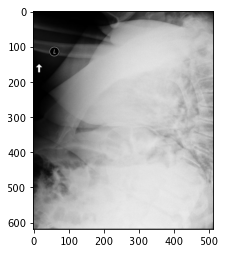

exam is technically limited by patient s body habitus  lung volumes are decreased  no evidence of acute airspace disease  large pleural effusion or pneumothorax  heart size is stable 



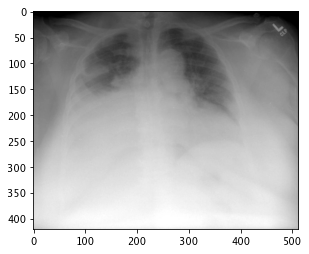

cardiomegaly  left lung clear  large right effusion  compressive atelectasis or infiltrate in the right base



In [6]:
for i in range(3):
    file_name = np.random.choice(df.Image)
    img = Image.open('/users/vspvikram/Downloads/AML_project/NLMCXR_png/' + file_name)
    plt.imshow(img)
    plt.show()
    print(df[df.Image == file_name].Caption.item())
    print()

# Visualization

In [7]:
texts = df.Caption.unique()
texts = functools.reduce(lambda a, b: a + b, texts).split()
texts = [i for i in texts if i not in set(stopwords.words('english'))]
words_counter = Counter(texts)

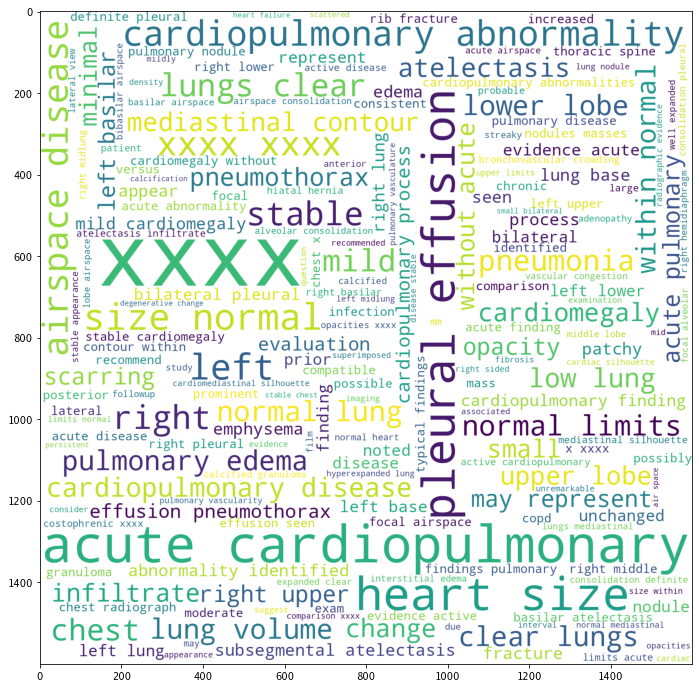

In [8]:
plt.figure(figsize=(12,12))
wordcloud = WordCloud(
    width=1600, height=1600,
    background_color = 'white',
    min_font_size=10).generate(" ".join(texts))

plt.imshow(wordcloud)
plt.show()

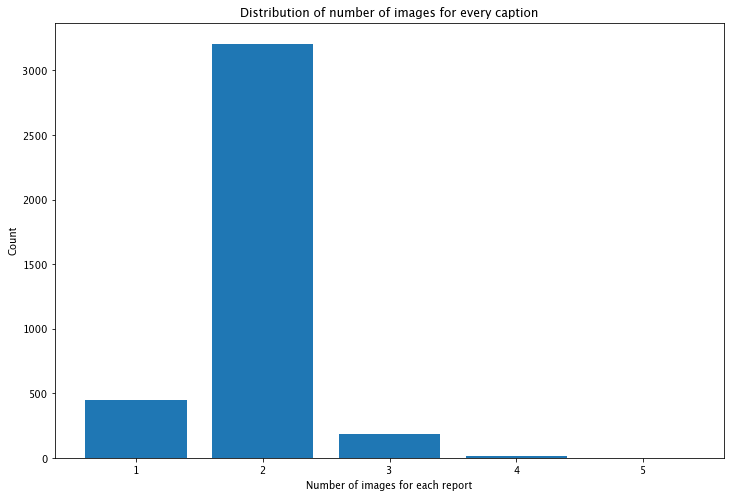

In [9]:
n_img = df.groupby(['Number']).size().value_counts().reset_index()
n_img.columns = ['Number of images', 'Count']

plt.figure(figsize=(12,8))
plt.bar(x=n_img['Number of images'], height=n_img['Count'])
plt.xlabel("Number of images for each report")
plt.ylabel("Count")
plt.title("Distribution of number of images for every caption")
plt.show()

In [10]:
df2 = df.copy()
df2['Img_count'] = df['Image'].groupby(df['Number']).transform('count')

# keeping only the 2 images per report files
df2 = df2[df2.Img_count == 2] 

Image_names = df2.groupby(['Number']).apply(lambda x: ', '.join(x.Image)).reset_index()
Image_names.rename(columns= {'Number': 'Number', 0: 'Image'})
df2 = df2[['Number', 'Caption']]
df2 = df2.drop_duplicates()
df2 = df2.merge(Image_names, on='Number')

df2.rename(columns={0: 'Images'}, inplace=True)
Images = df2['Images'].str.split(',', n=1, expand=True)
df2['Image1'] = Images[0]
df2['Image2'] = Images[1]
df2.drop(columns=['Images'], inplace=True)
df2

,Number,Caption,Image1,Image2
0,1,normal chest x xxxx,CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png
1,10,no acute cardiopulmonary process,CXR10_IM-0002-2001.png,CXR10_IM-0002-1001.png
2,100,no active disease,CXR100_IM-0002-2001.png,CXR100_IM-0002-1001.png
3,1001,diffuse fibrosis no visible focal acute disease,CXR1001_IM-0004-1001.png,CXR1001_IM-0004-1002.png
4,1002,status post left mastectomy heart size normal...,CXR1002_IM-0004-2001.png,CXR1002_IM-0004-1001.png
...,...,...,...,...
3203,994,negative chest,CXR994_IM-2478-2001.png,CXR994_IM-2478-1001.png
3204,995,post operative chest with no acute disease,CXR995_IM-2478-1002.png,CXR995_IM-2478-1001.png
3205,996,heart size is normal and lungs are clear no p...,CXR996_IM-2479-1001.png,CXR996_IM-2479-2001.png
3206,997,no acute cardiopulmonary abnormality,CXR997_IM-2479-1001.png,CXR997_IM-2479-2001.png


In [11]:
df2['Caption'].value_counts()[:20]

no acute cardiopulmonary abnormality                 265
no active disease                                    102
no acute cardiopulmonary abnormalities                97
no acute cardiopulmonary findings                     96
no acute disease                                      92
no acute cardiopulmonary disease                      77
no acute cardiopulmonary process                      56
1  no acute radiographic cardiopulmonary process      49
no evidence of active disease                         41
no acute pulmonary disease                            39
no acute cardiopulmonary abnormality                  38
1  no evidence of active disease                      38
no acute cardiopulmonary abnormality                  36
normal chest                                          32
no acute cardiopulmonary findings                     29
no acute findings                                     28
negative for acute abnormality                        27
no acute process               

In [12]:
df2['Caption_count'] = df2.groupby(['Caption'])['Number'].transform('count')
df2.head()

,Number,Caption,Image1,Image2,Caption_count
0,1,normal chest x xxxx,CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png,2
1,10,no acute cardiopulmonary process,CXR10_IM-0002-2001.png,CXR10_IM-0002-1001.png,56
2,100,no active disease,CXR100_IM-0002-2001.png,CXR100_IM-0002-1001.png,102
3,1001,diffuse fibrosis no visible focal acute disease,CXR1001_IM-0004-1001.png,CXR1001_IM-0004-1002.png,1
4,1002,status post left mastectomy heart size normal...,CXR1002_IM-0004-2001.png,CXR1002_IM-0004-1001.png,1


**Most of the above captions have similar meaning, that means having disease is rare and the data is not uniform in terms of the captions**

In [13]:
df2[df2.Caption_count < 6]['Caption_count'].value_counts() #39 types of captions are available in the dataset

1    1323
2      86
4      52
3      51
5      35
Name: Caption_count, dtype: int64

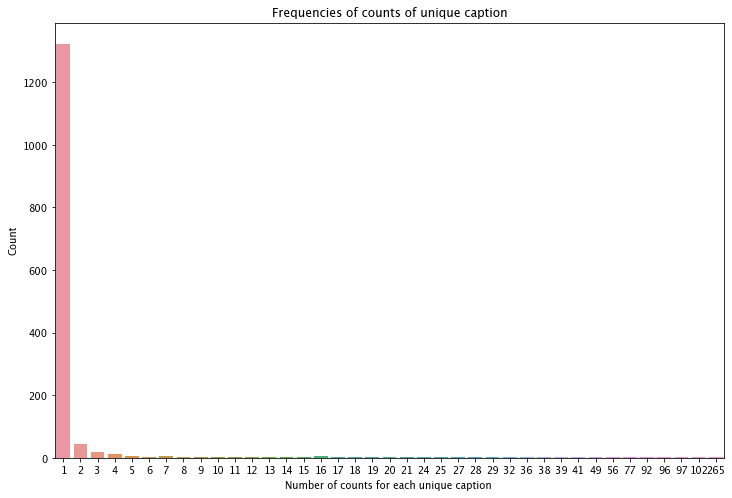

In [14]:

df_counts_unique = df2.Caption_count.value_counts().reset_index()
df_counts_unique['Caption_count_correct'] = df_counts_unique['Caption_count']/df_counts_unique['index']

plt.figure(figsize=(12,8))
ax = sns.barplot(x='index', y= 'Caption_count_correct', data = df_counts_unique)
plt.xlabel("Number of counts for each unique caption ")
plt.ylabel("Count")
plt.title("Frequencies of counts of unique caption")
plt.show()

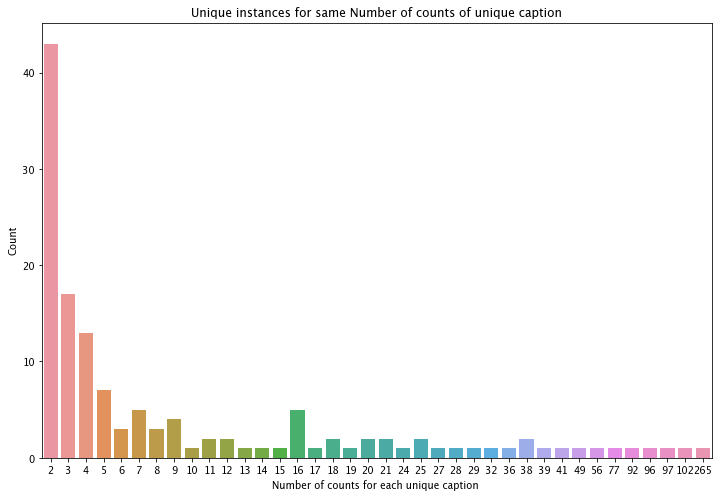

In [15]:
df_counts_unique_wt1 = df_counts_unique[df_counts_unique['index'] != 1]

plt.figure(figsize=(12,8))
ax = sns.barplot(x='index', y= 'Caption_count_correct', data = df_counts_unique_wt1)
plt.xlabel("Number of counts for each unique caption ")
plt.ylabel("Count")
plt.title("Unique instances for same Number of counts of unique caption")
plt.show()

# Creating train test Dataset

In [16]:


# Making separate df for rows having (>1 & < 6) caption count
ovsmpl_df = df2[(df2.Caption_count < 6) & (df2.Caption_count > 1)]
resampled = resample(ovsmpl_df, n_samples = int(0.2*ovsmpl_df.shape[0]), 
                     replace=False, random_state=42)

# Making separate df for rows having (==1) caption count
ovsmpl_df_count1 = df2[df2.Caption_count == 1]
resampled_count1 = resample(ovsmpl_df_count1, n_samples = int(0.2*ovsmpl_df_count1.shape[0]),
                            replace=False, random_state=43)

df3 = df2.drop(ovsmpl_df.index, axis=0)
df3 = df3.drop(ovsmpl_df_count1.index, axis=0)

train, test = train_test_split(df3, stratify = df3['Caption'].values, test_size=0.2, random_state=42)

test = test.append(resampled)
test = test.append(resampled_count1)
test = test.reset_index(drop=True)

ovsmpl_df = ovsmpl_df.drop(resampled.index, axis=0)
ovsmpl_df_count1 = ovsmpl_df_count1.drop(resampled_count1.index, axis=0)

train = train.append(ovsmpl_df)
train = train.append(ovsmpl_df_count1)

In [17]:
print(f'Train shape: {train.shape}\nTest shape:  {test.shape}') 

Train shape: (2567, 5)
Test shape:  (641, 5)


In [18]:
train.head()

,Number,Caption,Image1,Image2,Caption_count
1426,2625,no acute cardiopulmonary abnormality,CXR2625_IM-1112-0001-0002.png,CXR2625_IM-1112-0001-0001.png,265
1898,3163,no acute disease,CXR3163_IM-1488-1001.png,CXR3163_IM-1488-2001.png,92
1687,2924,no acute radiographic cardiopulmonary process,CXR2924_IM-1327-2001.png,CXR2924_IM-1327-1001.png,11
443,1512,no acute cardiopulmonary disease,CXR1512_IM-0332-2002.png,CXR1512_IM-0332-3003.png,20
1530,2742,no acute findings,CXR2742_IM-1197-2001.png,CXR2742_IM-1197-1001.png,28


In [19]:
def get_img_features(df, input_size):
    path = "/users/vspvikram/Downloads/AML_project/NLMCXR_png/"
    Xnet_features = {}
    for i in range(len(df)):
        image1 = cv2.imread(os.path.join(path, df.iloc[i]["Image1"].lstrip()), cv2.IMREAD_UNCHANGED)/255
        image1 = cv2.resize(image1, (input_size[0], input_size[1]), interpolation = cv2.INTER_NEAREST)
        image1 = np.array(image1).reshape(1,input_size[0],input_size[1],input_size[2])
        
        image2 = cv2.imread(os.path.join(path, df.iloc[i]["Image2"].lstrip()), cv2.IMREAD_UNCHANGED)/255
        image2 = cv2.resize(image2, (input_size[0], input_size[1]), interpolation = cv2.INTER_NEAREST)
        image2 = np.array(image2).reshape(1,input_size[0],input_size[1],input_size[2])

        en_model = Encoder()
        en_model.build(input_shape = (None, input_size[0],input_size[1],input_size[2]))

        image1_features = en_model.predict(image1)
        image2_features = en_model.predict(image2)
        input_concat = np.concatenate((image1_features, image2_features), axis=1)

        Xnet_features[int(df.iloc[i]['Number'])] = input_concat
    return Xnet_features

In [20]:
en_output = get_img_features(test.iloc[1:3], (224,224,3))

Metal device set to: Apple M1


2021-12-05 13:20:12.652302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-05 13:20:12.652745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-05 13:20:14.134909: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-05 13:20:14.137456: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-05 13:20:14.457369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-05 13:20:16.642073: I tensorflow/core/grappler/

In [21]:
len(en_output[131][0])

2048

In [53]:
class Dataset():
    def __init__(self, df,  path, 
                 input_size = (224,224,3),
                tokenizer=tokenizer):
        self.image1 = df.Image1
        self.image2 = df.Image2
        
        self.number = df.Number
        self.path = path
        self.input_size = input_size
        
        # preprocessing on the text
        # self.caption = df[caption_col].apply(lambda x: text_preprocess(x))
        self.tokenizer = tokenizer
        self.caption = df.Caption
    
        
    def __getitem__(self, i):
        image1 = cv2.imread(os.path.join(self.path, self.image1[i].lstrip()), cv2.IMREAD_UNCHANGED)/255
        image1 = cv2.resize(image1, (self.input_size[0], self.input_size[1]), interpolation = cv2.INTER_NEAREST)
        image1 = np.array(image1).reshape(1,self.input_size[0],self.input_size[1],self.input_size[2])
        
        image2 = cv2.imread(os.path.join(self.path, self.image2[i].lstrip()), cv2.IMREAD_UNCHANGED)/255
        image2 = cv2.resize(image2, (self.input_size[0], self.input_size[1]), interpolation = cv2.INTER_NEAREST)
        image2 = np.array(image2).reshape(1,self.input_size[0],self.input_size[1],self.input_size[2])
        
        # return the caption value
        caption = self.tokenizer.text_to_sequences(self.caption[i:i+1])
        
        
        return image1, image2, caption
    
    def text_preprocess(self, capt):
        capt = capt.split()

        capt = [word.lower() for word in capt]

        # remove punctuations from the string; like $#&
        table = str.maketrans('', '', string.punctuation)
        capt = [word.translate(table) for word in capt]

        # removing the hanging letters like s or t
        capt = [word for word in capt if len(word)>1] 
        capt = [word for word in capt if word not in STOP_WORDS]

        return ' '.join(capt)

In [54]:
vocabulary = set()
for i in range(len(train)):
    vocabulary.update(train.iloc[i]['Caption'].split())
len(vocabulary)

1300

In [55]:
df_t = train.copy()
df_t['Caption'] = df_t['Caption'].apply(lambda x: text_preprocess(x))


In [56]:
vocabulary = set()
for i in range(len(df_t)):
    vocabulary.update(df_t.iloc[i]['Caption'].split())
len(vocabulary)

1180

In [80]:
from tensorflow.keras.preprocessing.text import Tokenizer
a = "Now you4 sh&ould go bAck! go now now now go you4"
token = Tokenizer(num_words=10000)
token.fit_on_texts(train['Caption'])

In [81]:
token.get_config()

{'num_words': 10000,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': None,
 'document_count': 2567,
 'word_counts': '{"no": 2088, "acute": 1551, "cardiopulmonary": 1091, "abnormality": 563, "disease": 698, "radiographic": 96, "process": 224, "findings": 312, "evidence": 212, "of": 610, "active": 237, "heart": 227, "size": 212, "is": 260, "normal": 359, "and": 395, "the": 525, "lungs": 271, "are": 176, "clear": 248, "negative": 98, "for": 155, "1": 504, "pulmonary": 319, "comparison": 59, "xxxx": 750, "well": 48, "expanded": 43, "mediastinal": 120, "contour": 67, "within": 109, "limits": 107, "identified": 89, "stable": 173, "chest": 262, "preoperative": 14, "abnormalities": 134, "intrathoracic": 15, "finding": 29, "exam": 44, "x": 54, "emphysema": 46, "without": 107, "or": 266, "cardiac": 38, "pleural": 223, "cardiomediastinal": 18, "silhouette": 47, "vasculature": 24, "appears": 23, "there": 85, "focal": 103, "air"

In [82]:
token.texts_to_sequences([a])

[[831, 831, 831, 831]]

In [ ]:
token.